# Pacoes e classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from funcoes.buscar_dados import Temperature, Load
from funcoes.equacoes import  tabela_equacoes
from funcoes.graficos import plotar_graficos
from funcoes.farenheit_celsius import trocar_temp
import gridstatus as gs
from gridstatus import Ercot
import datetime as dt


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
df = pd.read_excel('C:/Users/joao.pinheiro/repos/tcc-serena/dados/tempeture_load.xlsx')
df.columns = ['interval_start_utc', 'interval_end_utc','publish_time_utc',
        'Unnamed', 'coast_carga', 'east_carga', 'far_west_carga', 'north_carga', 'north_central_carga',
        'south_central_carga', 'southern_carga', 'west_carga', 'sum_load', 'weekday', 'hour',
        'coast_tf', 'east_tf', 'far_west_tf', 'north_tf', 'north_central_tf',
        'south_central_tf', 'southern_tf', 'west_tf', 'avg_temp_fahrenheit']

df1 = df.copy()

In [24]:
colunas_fahrenheit = ['coast_tf',
                        'east_tf',
                        'far_west_tf',
                        'north_tf',
                        'north_central_tf',
                        'south_central_tf',
                        'southern_tf',
                        'west_tf',
                        'avg_temp_fahrenheit']

for col in colunas_fahrenheit:
    if col == 'avg_temp_fahrenheit':
        nova_col = 'avg_temp_celsius'
    else:
        nova_col = col.replace('_tf', '_tc')
    df1[nova_col] = (df1[col] - 32) * (5 / 9)

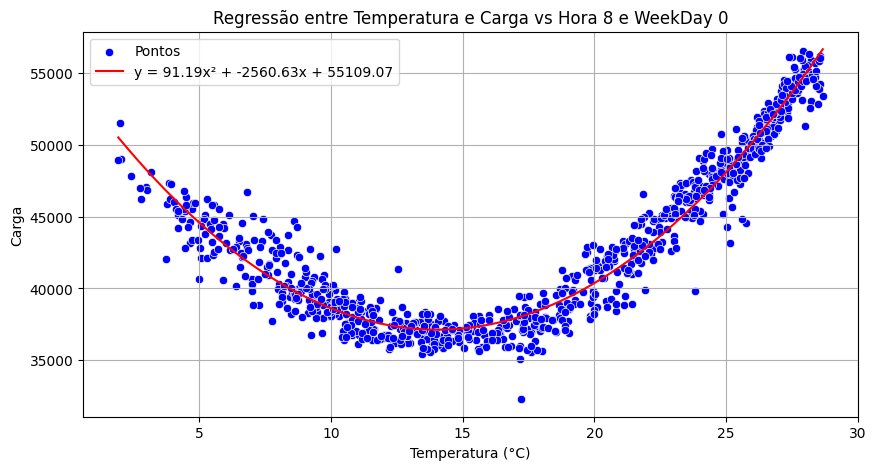

In [5]:
plotar_graficos(df = df1, hour= 8, weekday=0)

# Utilizando classes

In [2]:
# credencias
api_key = '41ac637ac7464f6da57351ed3fa5e5ff'
start_date = "2023-09-01"
end_date = "2024-09-01"

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!! aumentar horizonte de tempo

# # Temperatura
# temp = Temperature(api_key)
# df_temp = temp.get_df_temp(start_date, end_date)

# # Carga
# load = Load(api_key)
# df_load = load.get_df_load(start_date, end_date)


# df_temp.to_csv('df_temp.csv')
# df_load.to_csv('df_load.csv')

# Lendo arquivos baixados pela api
filtrar de 2023/09 até 2024/09 todas as horas da carga

In [2]:
# df_t = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_temp.csv')
# df_l = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_load.csv')

df_t = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_temp.csv')
df_l = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_load.csv')

In [3]:
# Tratamentos iniciais
for df in [df_l, df_t]:
    df["interval_start_utc"] = pd.to_datetime(df["interval_start_utc"]).dt.tz_localize(None)
    df["interval_end_utc"] = pd.to_datetime(df["interval_end_utc"], utc=True).dt.tz_localize(None)
    df["publish_time_utc"] = pd.to_datetime(df["publish_time_utc"], utc=True).dt.tz_localize(None)
    
df_t = df_t.drop(columns=["Unnamed: 0"], errors="ignore")
df_l = df_l.drop(columns=["Unnamed: 0", "publish_time_utc_load",'publish_time_utc_tf'], errors="ignore")


df_t = df_t[['interval_start_utc', 'interval_end_utc', 'publish_time_utc', 'coast',
        'east', 'far_west', 'north', 'north_central', 'south_central',
        'southern', 'west', 'hour', 'weekday', 'avg_temp_fahrenheit']]


In [4]:
df = pd.merge(
    df_l,
    df_t,
    on=["interval_start_utc", "interval_end_utc"],
    how="inner",
    suffixes=['_carga','_tf']
)

df = trocar_temp(df)
df['publish_time_utc_carga'] = pd.to_datetime(df['publish_time_utc_carga'])


hora = dt.time(10, 30) 
df = df[(df['publish_time_utc_carga'].dt.time == hora)]


# Qual dia da semana

In [5]:
df_dia_semana = df.copy()
df_dia_semana['dia'] = pd.to_datetime(df_dia_semana['publish_time_utc_carga']).dt.day_name()
df_dia_semana['ano']= pd.to_datetime(df_dia_semana['publish_time_utc_carga']).dt.year
df_dia_semana['mes']= pd.to_datetime(df_dia_semana['publish_time_utc_carga']).dt.month

df_dia_semana.replace([np.inf, -np.inf], np.nan, inplace=True)


# Gráficos de Carga média

In [ ]:
# Lista com os nomes das 9 regiões (colunas de carga)
regioes = [
    'coast_carga', 'east_carga', 'far_west_carga',
    'north_carga', 'north_central_carga', 'south_central_carga',
    'southern_carga', 'west_carga', 'system_total'
]

# Configura figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Criar gráfico para cada região
for i, regiao in enumerate(regioes):
    df_regiao = df_dia_semana.groupby(['mes', 'hour'])[regiao].mean().reset_index()

    sns.lineplot(
        data=df_regiao,
        x='hour',
        y=regiao,
        hue='mes',
        palette='tab10',
        ax=axes[i]
    )
    
    # Títulos e estética
    nome_formatado = regiao.replace('_carga', '').replace('_', ' ').title()
    axes[i].set_title(f'{nome_formatado}')
    axes[i].set_xlabel('Hora')
    axes[i].set_ylabel('Carga Média (MW)')
    axes[i].legend(title='Mês', fontsize='small', loc='upper right')

# Ajustes finais
plt.suptitle('Média Horária de Consumo por Região (MW)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Gráficos de temperatura média

In [ ]:
# Lista apenas com colunas de temperatura em Celsius
regioes_tc = [
    'coast_tc', 'east_tc', 'far_west_tc',
    'north_tc', 'north_central_tc', 'south_central_tc',
    'southern_tc', 'west_tc', 'avg_temp_celsius']

# Configura figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True) 
axes = axes.flatten()

# Criar gráfico para cada região
for i, regiao in enumerate(regioes_tc):
    df_regiao = df_dia_semana.groupby(['mes', 'hour'])[regiao].mean().reset_index()

    sns.lineplot(
        data=df_regiao,
        x='hour',
        y=regiao,
        hue='mes',
        palette='tab10',
        ax=axes[i]
    )
    
    # Títulos e estética
    nome_formatado = regiao.replace('_tc', '').replace('_', ' ').title()
    axes[i].set_title(f'{nome_formatado}')
    axes[i].set_xlabel('Hora')
    axes[i].set_ylabel('Temperatura (°C)')
    axes[i].legend(title='Mês', fontsize='small', loc='upper right')

# Ajustes finais
plt.suptitle('Média Horária de Temperatura por Região do Texas (°C)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [6]:
tabela_equacoes(df = df , n_weekday = 1 )

avg_temp_celsius sum_load
coast_tc coast_carga
east_tc east_carga
far_west_tc far_west_carga
north_tc north_carga
north_central_tc north_central_carga
south_central_tc south_central_carga
southern_tc southern_carga
west_tc west_carga


,Hora,avg_temp_celsius,coast_tc,east_tc,far_west_tc,north_tc,north_central_tc,south_central_tc,southern_tc,west_tc
0,0,y = 89.36x² -2424.62x + 55507.53,y = 25.74x² -737.48x + 15144.30,y = 3.50x² -101.87x + 2086.66,y = 2.14x² -52.82x + 6473.50,y = 2.19x² -48.88x + 1436.16,y = 29.17x² -807.08x + 15670.57,y = 16.20x² -423.32x + 8838.45,y = 9.16x² -287.16x + 5187.07,y = 1.95x² -53.86x + 1466.04
1,1,y = 89.65x² -2440.69x + 54394.81,y = 24.83x² -715.94x + 14761.71,y = 3.30x² -96.25x + 2002.96,y = 2.20x² -52.84x + 6439.73,y = 2.12x² -47.71x + 1405.28,y = 29.53x² -821.44x + 15325.52,y = 15.90x² -414.88x + 8500.17,y = 9.18x² -287.08x + 5048.38,y = 2.00x² -56.14x + 1460.57
2,2,y = 88.05x² -2391.05x + 53296.77,y = 23.05x² -653.19x + 14054.07,y = 3.32x² -98.18x + 1993.72,y = 2.10x² -46.66x + 6362.85,y = 2.11x² -47.76x + 1383.65,y = 28.97x² -802.85x + 14956.93,y = 15.37x² -402.99x + 8339.19,y = 8.79x² -274.18x + 4868.89,y = 1.96x² -55.03x + 1435.67
3,3,y = 87.43x² -2365.74x + 52880.95,y = 22.58x² -639.24x + 13937.15,y = 3.25x² -96.84x + 1980.81,y = 1.99x² -42.78x + 6319.51,y = 2.05x² -46.71x + 1380.41,y = 29.54x² -813.88x + 14892.72,y = 14.85x² -390.29x + 8254.68,y = 8.56x² -265.23x + 4763.10,y = 1.95x² -54.87x + 1424.98
4,4,y = 87.37x² -2371.47x + 53486.75,y = 21.92x² -619.26x + 13980.40,y = 3.26x² -98.64x + 2034.75,y = 1.98x² -41.48x + 6295.49,y = 2.05x² -46.83x + 1392.46,y = 29.03x² -803.35x + 15059.83,y = 14.02x² -368.99x + 8242.93,y = 8.79x² -277.89x + 4934.11,y = 1.94x² -54.96x + 1437.70
5,5,y = 87.18x² -2406.62x + 55868.94,y = 22.07x² -636.67x + 14735.61,y = 3.24x² -100.47x + 2147.52,y = 1.85x² -39.58x + 6306.06,y = 1.91x² -44.66x + 1446.71,y = 28.97x² -818.37x + 15980.37,y = 13.09x² -350.17x + 8558.41,y = 8.40x² -268.61x + 5037.75,y = 1.83x² -53.15x + 1482.30
6,6,y = 82.09x² -2335.92x + 59186.51,y = 20.27x² -596.45x + 15296.55,y = 2.92x² -95.19x + 2298.57,y = 1.62x² -35.68x + 6374.58,y = 1.78x² -43.38x + 1543.62,y = 26.40x² -769.20x + 17075.07,y = 12.63x² -359.13x + 9401.66,y = 7.64x² -250.78x + 5266.55,y = 1.69x² -52.10x + 1590.34
7,7,y = 80.11x² -2305.72x + 60753.66,y = 21.27x² -639.93x + 16021.37,y = 2.84x² -93.57x + 2351.84,y = 1.35x² -28.75x + 6364.89,y = 1.74x² -44.00x + 1601.57,y = 26.33x² -785.00x + 17924.60,y = 11.45x² -329.77x + 9583.37,y = 7.85x² -263.92x + 5540.03,y = 1.54x² -48.49x + 1625.83
8,8,y = 84.08x² -2412.44x + 61668.18,y = 22.56x² -688.51x + 16590.44,y = 3.09x² -99.07x + 2377.52,y = 2.07x² -47.89x + 6509.62,y = 1.79x² -43.72x + 1598.21,y = 26.39x² -776.50x + 17912.06,y = 14.29x² -419.30x + 10168.87,y = 8.63x² -293.52x + 5768.59,y = 1.53x² -44.37x + 1588.26
9,9,y = 87.84x² -2650.48x + 65128.78,y = 23.22x² -732.82x + 17390.56,y = 3.58x² -119.22x + 2592.76,y = 2.05x² -48.85x + 6611.81,y = 1.86x² -47.55x + 1642.21,y = 28.12x² -861.02x + 19000.34,y = 18.12x² -578.57x + 11696.81,y = 9.10x² -324.64x + 6227.02,y = 1.70x² -49.66x + 1644.41


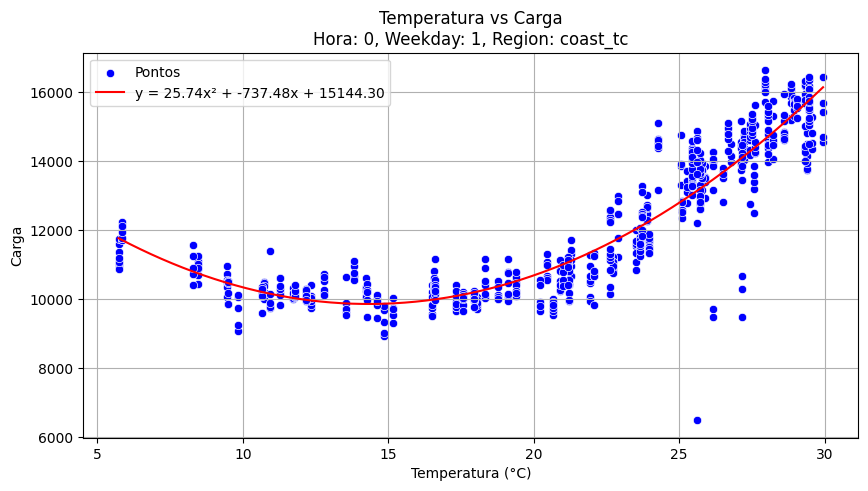

In [7]:
plotar_graficos(df= df , weekday= 1, hour= 0, region = 'coast_tc')

# teste 1
- treinamento com a carga total vs media simples temperatura do estado

# teste 2
- treinamento com a carga total vs media ponderada temperatura do estado (ponderada por carga historica ou população)


# teste 3
- treinamento com carga por weather_zone vs temperatura por weather zone (é o que eu ja fiz)